In [1]:
import numpy as np
from skimage import data
from skimage.color import *
from skimage.feature import *
from skimage.filters import *
import matplotlib.pyplot as plt
import math
from skimage.metrics import *
import skimage.io

In [2]:

def gaussian(sigma):
  #need to get an optimal size of kernel, which (by theory) can be choosen as follows
  sz = 2*math.ceil(3*sigma)+1;
  half_sz = sz//2;
  gaussian_kernel = np.full((sz,sz),0.0)
  for i in range(-half_sz,half_sz+1):
    for j in range(-half_sz,half_sz+1):
      x1 = 2*np.pi*sigma*sigma;
      x2 = math.exp(-(i*i +j*j)/(2*sigma*sigma))
      gaussian_kernel[i+half_sz][j+half_sz] = x2/x1;

  return gaussian_kernel


def convolve(image,kernel):
  r,c = image.shape
 
  sz = kernel.shape[0]
  mid_sz = sz//2
  # padd real values
  image = np.pad(image, pad_width= sz // 2, mode='constant', constant_values=0).astype(np.float32)

  modimg = np.zeros((r,c))
  for i in range(mid_sz,r+mid_sz):
    for j in range(mid_sz,c+mid_sz):
      
     
      temp = (image[i-mid_sz:i-mid_sz+sz,j-mid_sz:j-mid_sz+sz]).flatten()
      temp1 = kernel.flatten()
      new_val = temp1 * temp
      modimg[i-mid_sz,j-mid_sz] = new_val.sum()

  return modimg


def non_max_suppression(theta,image):
  r,c = image.shape
  new_img = np.full((r,c),0.0)
  for i in range(r):
    for j in range(c):
      theta[i,j] = (theta[i,j]/np.pi)*180
      if(theta[i,j]<0):
        theta[i,j]+=180
  for i in range(1,r-1):
    for j in range(1,c-1):
      temp = theta[i,j]
      n1=0;
      n2=0;
      
      if(0<=temp<22.5 or 157.5<=temp<=180):
        n1 = image[i,j+1]
        n2 = image[i,j-1]

      elif(22.5<=temp<67.5):
         n1 = image[i-1,j+1]
         n2 = image[i+1,j-1]

      elif(67.5<=temp<112.5):
          n1 = image[i-1,j]
          n2 = image[i+1,j]

      elif(112.5<=temp<157.5):
         n1 = image[i-1,j-1]
         n2 = image[i+1,j+1]
      if image[i,j] >= n1 and image[i,j]>=n2:
        new_img[i,j] = image[i,j]
      else:
        new_img[i,j] =0.0
 
  return new_img


def double_threshold(h_val, l_val,image):
  #0 non-relevant value
  #2 strong value
  #1 weak value
  classified = np.full(image.shape,0.0);
  r,c = image.shape
  for i in range(r):
    for j in range(c):
      if(image[i,j]>h_val):
        classified[i,j]=2.0
      elif(image[i,j]<l_val):
        classified[i,j]=0.0
      else:
        classified[i,j]=1.0

  return classified

#sigma value taken  by me, for gaussian blur, only edit here to check sigma
sigma = 2
def myCannyEdgeDetector2(grayim,high_val,low_val):
  
  #gaussian blur
  gaussian_kernel = gaussian(sigma);
  new_im = convolve(grayim,gaussian_kernel)

  #sobel
  kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).astype(np.float32)
  ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).astype(np.float32)
  x_iter = -1*convolve(new_im,kx)
  y_iter = -1*convolve(new_im,ky)

  g_sum = np.full(x_iter.shape,0.0)
  for i in range(x_iter.shape[0]):
    for j in range(x_iter.shape[1]):
      g_sum[i,j] = math.sqrt(x_iter[i,j]**2 + y_iter[i,j]**2)
  
  theta_angles = np.arctan2(y_iter, x_iter)

  #non max suppression
  modified_non_max_suppression = non_max_suppression(theta_angles,g_sum)
  
  #defined low_val/high_val for thresholding
  low_val = low_val * modified_non_max_suppression.max();
  high_val = high_val * modified_non_max_suppression.max();
  
  # classify pixel into weak,non relevant and strong edges
  classified_mat = double_threshold(high_val,low_val,modified_non_max_suppression)

  #hystersis/ double thresholding
  final_out = np.full(modified_non_max_suppression.shape,0)
  r=modified_non_max_suppression.shape[0]
  c=modified_non_max_suppression.shape[1]

  for i in range(r):
    for j in range(c):
      if(classified_mat[i,j]==2):
        final_out[i,j] = 255
      elif(classified_mat[i,j]==0):
        final_out[i,j] =0;

  for i in range(1,r-1):
    for j in range(1,c-1):
      if(classified_mat[i,j]==1):
        if (final_out[i+1,j]==255 or final_out[i+1,j-1]==255 or final_out[i+1,j+1]==255 or final_out[i-1,j-1]==255 or final_out[i-1,j+1]==255 or final_out[i-1,j]==255 or final_out[i,j+1]==255 or final_out[i,j-1]==255 ):
          final_out[i,j] =255
        else:
          final_out[i,j]=0

  for i in range(r):
    for j in range(c):
      if(final_out[i,j]==255):
        final_out[i,j] = True
      elif(final_out[i,j]==0):
        final_out[i,j] = False;
  

  # CASE@2: 
  idle = canny(grayim, sigma = sigma,low_threshold= low_val,high_threshold = high_val)
  return final_out,idle


  #CASE@1: 
  # return final_out

def myCannyEdgeDetector(grayim,high_val,low_val):
  
  #gaussian blur
  gaussian_kernel = gaussian(sigma);
  new_im = convolve(grayim,gaussian_kernel)

  #sobel
  kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).astype(np.float32)
  ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).astype(np.float32)
  x_iter = -1*convolve(new_im,kx)
  y_iter = -1*convolve(new_im,ky)

  g_sum = np.full(x_iter.shape,0.0)
  for i in range(x_iter.shape[0]):
    for j in range(x_iter.shape[1]):
      g_sum[i,j] = math.sqrt(x_iter[i,j]**2 + y_iter[i,j]**2)
  
  theta_angles = np.arctan2(y_iter, x_iter)

  #non max suppression
  modified_non_max_suppression = non_max_suppression(theta_angles,g_sum)
  
  #defined low_val/high_val for thresholding
  low_val = low_val * modified_non_max_suppression.max();
  high_val = high_val * modified_non_max_suppression.max();
  
  # classify pixel into weak,non relevant and strong edges
  classified_mat = double_threshold(high_val,low_val,modified_non_max_suppression)

  #hystersis/ double thresholding
  final_out = np.full(modified_non_max_suppression.shape,0)
  r=modified_non_max_suppression.shape[0]
  c=modified_non_max_suppression.shape[1]

  for i in range(r):
    for j in range(c):
      if(classified_mat[i,j]==2):
        final_out[i,j] = 255
      elif(classified_mat[i,j]==0):
        final_out[i,j] =0;

  for i in range(1,r-1):
    for j in range(1,c-1):
      if(classified_mat[i,j]==1):
        if (final_out[i+1,j]==255 or final_out[i+1,j-1]==255 or final_out[i+1,j+1]==255 or final_out[i-1,j-1]==255 or final_out[i-1,j+1]==255 or final_out[i-1,j]==255 or final_out[i,j+1]==255 or final_out[i,j-1]==255 ):
          final_out[i,j] =255
        else:
          final_out[i,j]=0

  for i in range(r):
    for j in range(c):
      if(final_out[i,j]==255):
        final_out[i,j] = True
      elif(final_out[i,j]==0):
        final_out[i,j] = False;
  

  # CASE@2: 
  # idle = canny(grayim, sigma = sigma,low_threshold= low_val,high_threshold = high_val)
  # return final_out,idle


  #CASE@1: 
  return final_out



  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


PSNR1 = 21.66901701503449
SSIM1 = 0.9559713762208042
PSNR2 = 23.582198932633762
SSIM2 = 0.9729526810178482


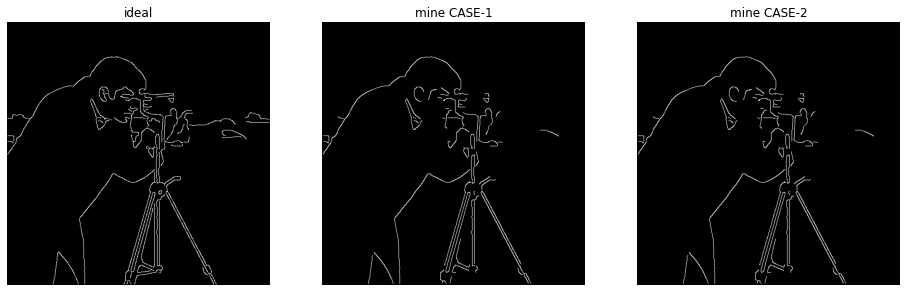

In [3]:

# test_image input

# test_image = data.brick();
test_image = data.camera();
# test_image = data.page();
# test_image = data.text();
# test_image = data.human_mitosis();
# test_image = data.moon();

#convert to gray
grayim = rgb2gray(test_image)

#outputs my canny edge detected image,#ideal case from inbuilt canny edge detector
final_out = myCannyEdgeDetector(grayim,0.4,0.2)
idle = canny(grayim, sigma = sigma,low_threshold= 0.2*255,high_threshold = 0.4*255)


# #CASE-@2 : DO NOT UNCOMMENT
final_out2,idle2 = myCannyEdgeDetector2(grayim,0.4,0.2)




fig, axes = plt.subplots(1, ncols=3, figsize=(16, 8))
axes[0].imshow(idle,cmap='gray')
axes[0].axis('off')
axes[0].set_title('ideal')
axes[1].imshow(final_out,cmap='gray')
axes[1].axis('off')
axes[1].set_title('mine CASE-1')
axes[2].imshow(final_out2,cmap='gray')
axes[2].axis('off')
axes[2].set_title('mine CASE-2')

#metrics
comparison_PSNR = peak_signal_noise_ratio(idle,final_out)
SSIM = structural_similarity(idle,final_out)
comparison_PSNR2 = peak_signal_noise_ratio(idle2,final_out2)
SSIM2 = structural_similarity(idle2,final_out2)

print("PSNR1 = "+str(comparison_PSNR))
print("SSIM1 = "+str(SSIM))

print("PSNR2 = "+str(comparison_PSNR2))
print("SSIM2 = "+str(SSIM2))

